## Hypothesis Testing for Lead/Lag Analysis with Daily Emotions and Migration

#### Author: Eliza Salamon

Importing and cleaning data

In [104]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
#get migration patterns
flow_df = pd.read_csv('hcr_dat_border.csv')
countries_of_interest = ['Slovakia', 'Hungary', 'Poland', 'Republic of Moldova']
flow_df = flow_df[flow_df.Country.isin(countries_of_interest)]
flow_df['data_date'] = pd.to_datetime(flow_df['data_date'], format='%d/%b/%Y')
flow_df.drop(columns=['iso3', 'Country'], inplace=True)
flow_df.rename(columns={"data_date": 'date', ' Border_Crossings ' : 'border_crossings'}, inplace=True)
flow_df['border_crossings'] = flow_df['border_crossings'].str.replace(',', '')
flow_df['border_crossings'] = flow_df['border_crossings'].str.replace('-', '0')
flow_df['border_crossings'] = flow_df['border_crossings'].str.strip().astype('int')
flow_df = flow_df.groupby(['date']).sum()
flow_df.head()

,border_crossings
date,
2022-02-24,65846
2022-02-25,90155
2022-02-26,131865
2022-02-27,154046
2022-02-28,149041


In [106]:
#get emotion data
df_emotion = pd.read_csv('../Indicators/Emotion/binary_predictions_2022.csv')
df_emotion.drop(columns=df_emotion.columns[0], inplace=True)
df_emotion['date'] = pd.to_datetime(df_emotion['date'], format='%Y-%m-%d')
df_emotion = df_emotion[df_emotion['predicted_emotion'] != 'others'] #comment this out if you want to include others in hyptothesis testing
df_emotion.head()

,date,city,tweet,predicted_emotion
2,2022-10-22,Хмельницький,RT @superumka: Луцьк і Хмельницький просять на...,joy
3,2022-10-22,Хмельницький,Хмельницький після вранішніх вибухів опинився ...,sadness
4,2022-10-22,Хмельницький,RT @tsnua: Хмельницький після вранішніх вибухі...,sadness
7,2022-10-22,Хмельницький,RT @superumka: Луцьк і Хмельницький просять на...,joy
8,2022-10-22,Миколаїв,"RT @OlenaBek60: Миколаїв без світла, але у Каш...",joy


In [107]:
#group by emotion count
df_emotion = df_emotion.groupby(['date', 'predicted_emotion']).count()
df_emotion.drop(columns=['city'], inplace=True)

In [108]:
#get sentiment data
df_sentiment = pd.read_csv('binary_sentiment_predictions_2022.csv')
df_sentiment.drop(columns=df_sentiment.columns[0], inplace=True)
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'], format='%Y-%m-%d')
df_sentiment = df_sentiment[df_sentiment['predicted_sentiment'] != 'neutral'] #comment this out if you want to include others in hyptothesis testing
df_sentiment.head()

,date,city,tweet,predicted_sentiment
0,2022-11-17,Миколаїв,Глава дипломатії Європейського Союзу Жозеп Бор...,negative
2,2022-11-17,Херсон,Президент України Володимир Зеленський відпові...,negative
3,2022-11-17,Херсон,У визволений від російських загарбників Херсон...,negative
4,2022-11-17,Херсон,В Україні з'явиться реєстр збитків від агресії...,negative
5,2022-11-17,Херсон,Російська влада не буде вести публічних перего...,negative


In [109]:
df_sentiment = df_sentiment.groupby(['date', 'predicted_sentiment']).count()
df_sentiment.drop(columns=['city'], inplace=True)
df_sentiment.head()


tweet
date       predicted_sentiment       
2022-02-01 negative                64
           positive                28
2022-02-02 negative                38
           positive                22
2022-02-03 negative                48

In [110]:
merged_emo = flow_df.merge(df_emotion, left_index=True, right_index=True, how='inner')
merged_sent = flow_df.merge(df_sentiment, left_index=True, right_index=True, how='inner')
print(merged_emo.head())
print(merged_sent.head())

                              border_crossings  tweet
date       predicted_emotion                         
2022-02-24 joy                           65846      6
           sadness                       65846      1
2022-02-25 anger                         90155     14
           fear                          90155      5
           joy                           90155     14
                                border_crossings  tweet
date       predicted_sentiment                         
2022-02-24 negative                        65846    195
           positive                        65846    230
2022-02-25 negative                        90155     75
           positive                        90155    126
2022-02-26 negative                       131865     56


In [111]:
#reindex so all emotion/date combos are present
all_dates = pd.date_range(np.min(merged_emo.index.get_level_values('date')), np.max(merged_emo.index.get_level_values('date')))
all_emotions = list(set(merged_emo.index.get_level_values('predicted_emotion')))
ind2 = pd.MultiIndex.from_product([all_dates,all_emotions], names = ['date','emotion'])
merged_emo = merged_emo.reindex(ind2, fill_value = 0) 
merged_emo.index = merged_emo.index.set_levels([pd.to_datetime(merged_emo.index.levels[0]), merged_emo.index.levels[1]])
merged_emo.drop(columns=['border_crossings'], inplace=True)
merged_emo.head()

tweet
date       emotion       
2022-02-24 anger        0
           fear         0
           sadness      1
           joy          6
2022-02-25 anger       14

In [112]:
#graphing colors
emotions_colors  = {
    "anger": "#8A0000",
    "fear": "#B57EDC",
    "sadness": "#0000FF",
    "disgust": "#006400",
    "joy": "#FFD700",
    "others": "black",
    "positive": "#8AFF8A",
    "negative": "#FF8A8A",
}

In [113]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
for r in all_emotions:
    ax.plot(merged_emo.xs(r,level=1).loc[:,'tweet'], label = r, color=emotions_colors[r])
for s in ['negative', 'positive']:
    ax.plot(merged_sent.xs(s, level=1).loc[:, 'tweet'], label=s, color=emotions_colors[s])
ax2.plot(flow_df.index.values, flow_df.border_crossings.values, color='black', linestyle='dashed')
ax.set_ylabel('Emotion count', fontsize=16)
ax2.set_ylabel('Border Crossings', fontsize=16)
ax.legend()

## Correlations for lead/lag with raw counts

In [ ]:
offset_range = np.arange(-15, 15)
emotions = all_emotions.copy()
# #emotions.remove('others')

#emotions
corr_dict_emo = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in corr_dict_emo.keys():
            shift = merged_emo.xs(e,level=1).loc[:,'tweet'].shift(i)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict_emo[e].append(corr)

#sentiment
corr_dict_sent = {'positive':[], 'negative': []}
for i in offset_range:
    for e in corr_dict_sent.keys():
            shift = merged_sent.xs(e,level=1).loc[:,'tweet'].shift(i)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict_sent[e].append(corr)

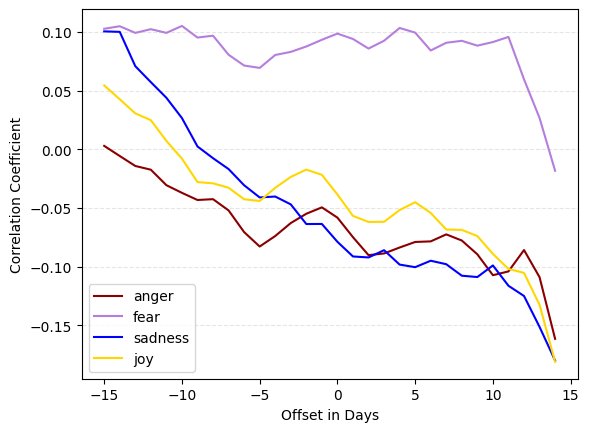

In [ ]:
#graph all correlations from -2 weeks to +2 weeks 
fig = plt.figure()
for i in emotions:
    plt.plot(offset_range, corr_dict_emo[i], label=i, color=emotions_colors[i])
for i in ['positive', 'negative']:
    plt.plot(offset_range, corr_dict_sent[i], label=i, color=emotions_colors[i])
plt.xlabel('Offset in Days')
plt.ylabel('Correlation Coefficient')
plt.legend()
ax = plt.gca()
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.2)
plt.show()


Lead Lag clarification:  

positive shift (leading indicator) 
Emotions predicting migration: At around 2 weeks before migration, tweets have negative correlations except fear (may be valuable to predict later migration)

negative shift (lagging indicator)
Migration predicting emotions: Positive relationship the further apart migration and emotion get
note: the bigger the absolute value of the shift is, the less data points there are that line up which alone may increase correlations



In [ ]:
offset_range = np.arange(0, 30)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in emotions:
            shift = merged_emo.xs(e,level=1).loc[:,'tweet'].shift(i)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr)

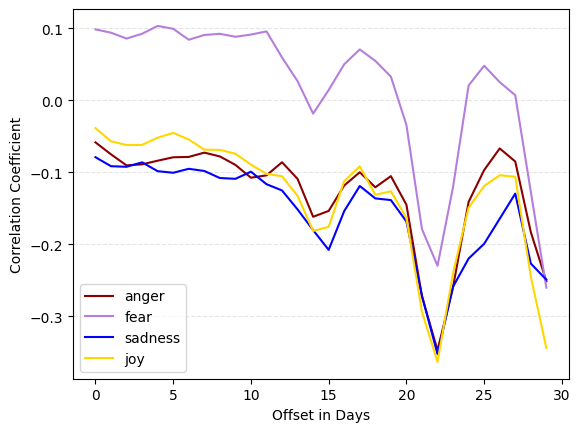

In [ ]:
#graph all correlations to one month shift
fig = plt.figure()
for i in emotions:
    plt.plot(offset_range, corr_dict[i], label=i, color=emotions_colors[i])
plt.xlabel('Offset in Days')
plt.ylabel('Correlation Coefficient')
plt.legend()
ax = plt.gca()
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.2)
plt.show()


## Correlations for lead/lag with proportions

In [ ]:
merged_emo['proportion'] = merged_emo.groupby(level=0).apply(lambda x: x/x.sum())['tweet'].values
merged_emo.head()

tweet  proportion
date       emotion                   
2022-02-24 anger        0    0.000000
           fear         0    0.000000
           sadness      1    0.142857
           joy          6    0.857143
2022-02-25 anger       14    0.368421

In [ ]:
offset_range = np.arange(-14, 15)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in emotions:
            shift = merged_emo.xs(e,level=1).loc[:,'proportion'].shift(i)
            print(shift)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr)

date
2022-02-24    0.251429
2022-02-25    0.180095
2022-02-26    0.228856
2022-02-27    0.189944
2022-02-28    0.293785
                ...   
2022-10-14         NaN
2022-10-15         NaN
2022-10-16         NaN
2022-10-17         NaN
2022-10-18         NaN
Freq: D, Name: proportion, Length: 237, dtype: float64
date
2022-02-24    0.017143
2022-02-25    0.066351
2022-02-26    0.069652
2022-02-27    0.067039
2022-02-28    0.079096
                ...   
2022-10-14         NaN
2022-10-15         NaN
2022-10-16         NaN
2022-10-17         NaN
2022-10-18         NaN
Freq: D, Name: proportion, Length: 237, dtype: float64
date
2022-02-24    0.171429
2022-02-25    0.213270
2022-02-26    0.348259
2022-02-27    0.245810
2022-02-28    0.152542
                ...   
2022-10-14         NaN
2022-10-15         NaN
2022-10-16         NaN
2022-10-17         NaN
2022-10-18         NaN
Freq: D, Name: proportion, Length: 237, dtype: float64
date
2022-02-24    0.560000
2022-02-25    0.540284
2022-02-26

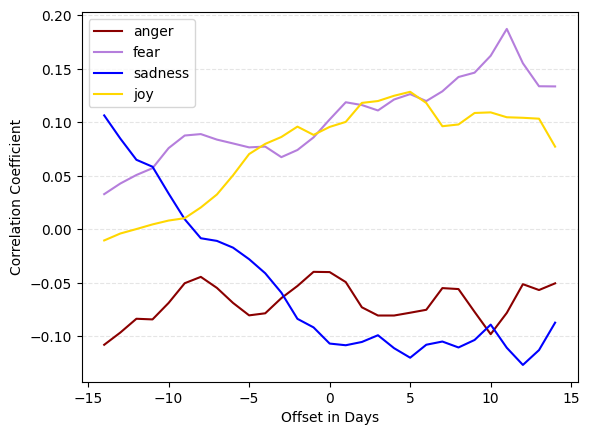

In [ ]:
fig = plt.figure()
for i in emotions:
    plt.plot(offset_range, corr_dict[i], label=i, color=emotions_colors[i])
plt.xlabel('Offset in Days')
plt.ylabel('Correlation Coefficient')
plt.legend()
ax = plt.gca()
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.2)
plt.show()


In [ ]:
unstacked_prop = merged_emo['proportion'].unstack(level=1)
correlations = pd.concat([unstacked_prop,flow_df['border_crossings']], axis=1).corr()['border_crossings']
print(correlations)

anger              -0.040011
fear                0.102484
joy                 0.095544
sadness            -0.106747
border_crossings    1.000000
Name: border_crossings, dtype: float64


## Correlation for lead/lag with difference from mean

In [ ]:
merged_emo['mean_diff'] = merged_emo['tweet'] - merged_emo.groupby(level=0).mean()['tweet']
merged_emo.head()

tweet  proportion  mean_diff
date       emotion                              
2022-02-24 anger        0    0.000000      -1.75
           fear         0    0.000000      -1.75
           sadness      1    0.142857      -0.75
           joy          6    0.857143       4.25
2022-02-25 anger       14    0.368421       4.50

In [ ]:
offset_range = np.arange(-14, 14)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in emotions:
            shift = merged_emo.xs(e,level=1).loc[:,'mean_diff'].shift(i)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr)

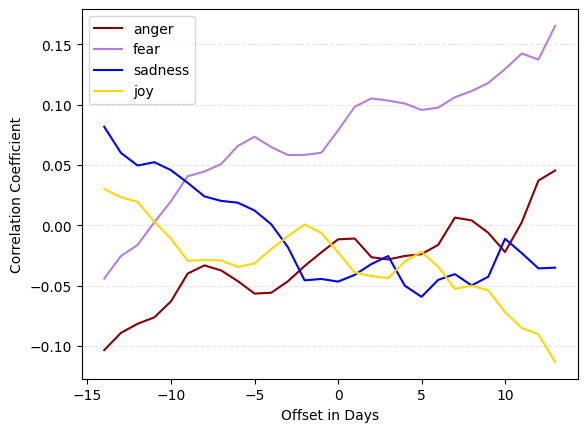

In [ ]:
fig = plt.figure()
for i in emotions:
    plt.plot(offset_range, corr_dict[i], label=i, color=emotions_colors[i])
plt.xlabel('Offset in Days')
plt.ylabel('Correlation Coefficient')
plt.legend()
ax = plt.gca()
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.2)
plt.show()


In [ ]:
def corrMat(covars, responses, df):
    corrMat = pd.DataFrame(columns=covars, index=responses)
    for c2 in covars:
        for c1 in responses:
            corrMat.at[c1, c2] = df[c2].corr(df[c1])
    return corrMat

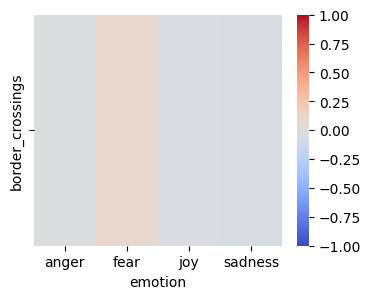

In [ ]:
unstacked_mean = merged_emo['mean_diff'].unstack(level=1)
correlations = pd.concat([unstacked_mean,flow_df['border_crossings']], axis=1)
cm = corrMat(unstacked_mean.columns, ['border_crossings'], correlations)
plt.figure(figsize=(4, 3))
sns.heatmap(cm.astype(float), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()